### QF609 - Risk Analysis

#### Group 6 Members - 
1. Prasad Dhamane
2. Krish Shah
3. Hwa Ming
4. Sshubh Naik
5. Varun Chitalia
6. Urvaansh Baid

We have the following portfolio of positions as of 30/10/2023:

(a) a payer (i.e. pay fixed leg and receive float leg) SOFR swap with the following contract parameters:

- Notional: $100 million
- Starting Date: 30/10/2023
- Maturity: 10Y
- Strike: 4.2%
- FloatLeg Frequency: Annual
- FixedLeg Frequency: Annual

(b) $1 million in each of the four stocks: AAPL, MSFT, F (Ford Motor) and BAC (Bank of America)

Our aim is to calculate the 1-day 95% VaR for the portfolio as of 30/10/2023 using each of the following
models:
- Parametric VaR Model
- Monte Carlo VaR Model (under both full revaluation and risk-based approaches)
- Historical VaR Model (under both full revaluation and risk-based approaches)

In [139]:
#Define Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from enum import Enum
from matplotlib.ticker import FuncFormatter
pd.set_option('display.float_format', lambda x: '%.8f' % x)

### Data

In [140]:
#Data Import and Preprocessing
sofr = pd.read_excel('hist_data.xlsm', sheet_name='SofrCurve',index_col=0)
stock = pd.read_excel('hist_data.xlsm', sheet_name='Stock', index_col=0)

SOFR = sofr.iloc[:,1:].T.reset_index(drop=True)
Stock = stock.reset_index(drop=True)

sofrDailyChanges = (SOFR - SOFR.shift(1)).dropna()
stockDailyChanges = Stock.pct_change().dropna()

Data = pd.concat([sofrDailyChanges, stockDailyChanges], axis=1)

#working only with required data 
data = pd.concat([Data.iloc[:,6:16], Data.iloc[:,30:]], axis=1)

mean_of_risk_factor = pd.DataFrame(data.mean(),columns=['Mean']).T
covariance_of_risk_factor = data.cov()

In [141]:
SOFR.head()

Tenor,1D,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,15Y,16Y,17Y,18Y,19Y,20Y,25Y,30Y,35Y,40Y
0,0.03919094,0.03872102,0.03867037,0.04053642,0.04457700,0.04600433,0.04644879,0.04458288,0.04200217,0.04031778,...,0.03715136,0.03705744,0.03690668,0.03669833,0.03643344,0.03611146,0.03409097,0.03235047,0.03055228,0.02870805
1,0.03960427,0.03902333,0.03888639,0.04072459,0.04484880,0.04644829,0.04696972,0.04502184,0.04234406,0.04061418,...,0.03680209,0.03668199,0.03651127,0.03628738,0.03601006,0.03567761,0.03364517,0.03197896,0.03023786,0.02847810
2,0.03994842,0.03928573,0.03910008,0.04085224,0.04488429,0.04657991,0.04720348,0.04549583,0.04274856,0.04086827,...,0.03685514,0.03670121,0.03649831,0.03624774,0.03595250,0.03561327,0.03362693,0.03193608,0.03029200,0.02860788
3,0.04038879,0.03958508,0.03935034,0.04115385,0.04528138,0.04710657,0.04789377,0.04659377,0.04383321,0.04182514,...,0.03722094,0.03706897,0.03688588,0.03665688,0.03637206,0.03602198,0.03381069,0.03213381,0.03040746,0.02865482
4,0.04596499,0.04234342,0.03879539,0.04061070,0.04521199,0.04675201,0.04749967,0.04609710,0.04338527,0.04150268,...,0.03768724,0.03755742,0.03738018,0.03715157,0.03687026,0.03653365,0.03442404,0.03255766,0.03072258,0.02893253


In [142]:
stock.head()

,AAPL,MSFT,F,BAC
Date,,,,
2022-10-31,152.04112200,229.44320700,11.97438000,34.74858100
2022-11-01,149.37391700,225.52903700,12.00124800,34.90284700
2022-11-02,143.80151400,217.55244400,11.69674000,34.79678300
2022-11-03,137.70361300,211.77015700,11.87586300,34.60395400
2022-11-04,137.43545500,218.82751500,12.09976700,35.47170300


In [143]:
sofrDailyChanges.head()

Tenor,1D,1M,2M,3M,6M,9M,1Y,2Y,3Y,4Y,...,15Y,16Y,17Y,18Y,19Y,20Y,25Y,30Y,35Y,40Y
1,0.00041333,0.00030231,0.00021603,0.00018817,0.00027180,0.00044396,0.00052094,0.00043895,0.00034189,0.00029639,...,-0.00034927,-0.00037546,-0.00039541,-0.00041095,-0.00042337,-0.00043385,-0.00044580,-0.00037151,-0.00031442,-0.00022995
2,0.00034415,0.00026240,0.00021369,0.00012765,0.00003549,0.00013162,0.00023376,0.00047399,0.00040450,0.00025409,...,0.00005305,0.00001922,-0.00001296,-0.00003964,-0.00005756,-0.00006434,-0.00001823,-0.00004287,0.00005414,0.00012978
3,0.00044037,0.00029935,0.00025026,0.00030161,0.00039709,0.00052666,0.00069029,0.00109794,0.00108465,0.00095687,...,0.00036580,0.00036777,0.00038758,0.00040914,0.00041956,0.00040871,0.00018376,0.00019773,0.00011546,0.00004694
4,0.00557620,0.00275835,-0.00055495,-0.00054316,-0.00006939,-0.00035456,-0.00039411,-0.00049666,-0.00044793,-0.00032247,...,0.00046630,0.00048845,0.00049430,0.00049469,0.00049820,0.00051168,0.00061335,0.00042386,0.00031512,0.00027771
5,-0.00574093,-0.00308498,0.00066509,0.00081307,0.00024332,0.00043703,0.00042922,0.00053617,0.00049908,0.00041284,...,0.00043104,0.00046348,0.00048749,0.00050365,0.00051228,0.00051378,0.00049809,0.00057708,0.00057729,0.00056235


In [144]:
stockDailyChanges.head()

,AAPL,MSFT,F,BAC
1,-0.01754266,-0.01705943,0.00224379,0.00443949
2,-0.03730506,-0.03536836,-0.02537303,-0.00303884
3,-0.04240498,-0.02657882,0.01531393,-0.00554158
4,-0.00194736,0.03332555,0.01885370,0.02507659
5,0.00390209,0.02926969,0.01406358,0.00597987


In [145]:
data.head()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,AAPL,MSFT,F,BAC
1,0.00052094,0.00043895,0.00034189,0.00029639,0.00022521,0.00012398,0.00002863,-0.00004296,-0.00009724,-0.00014377,-0.01754266,-0.01705943,0.00224379,0.00443949
2,0.00023376,0.00047399,0.00040450,0.00025409,0.00015275,0.00011817,0.00010912,0.00009867,0.00008995,0.00009143,-0.03730506,-0.03536836,-0.02537303,-0.00303884
3,0.00069029,0.00109794,0.00108465,0.00095687,0.00083215,0.00076078,0.00070377,0.00062393,0.00054466,0.00049534,-0.04240498,-0.02657882,0.01531393,-0.00554158
4,-0.00039411,-0.00049666,-0.00044793,-0.00032247,-0.00020398,-0.00011554,-0.00003787,0.00004548,0.00012582,0.00019215,-0.00194736,0.03332555,0.01885370,0.02507659
5,0.00042922,0.00053617,0.00049908,0.00041284,0.00033189,0.00031279,0.00032836,0.00034171,0.00034529,0.00033932,0.00390209,0.02926969,0.01406358,0.00597987


In [146]:
mean_of_risk_factor.head()

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,AAPL,MSFT,F,BAC
Mean,0.00002318,0.00001329,0.00001371,0.00001611,0.00001852,0.00002104,0.00002320,0.00002472,0.00002580,0.00002668,0.00056800,0.00169220,-0.00061889,-0.00110510


In [147]:
covariance_of_risk_factor

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,AAPL,MSFT,F,BAC
1Y,0.00000064,0.00000069,0.00000061,0.00000056,0.00000050,0.00000046,0.00000043,0.00000040,0.00000038,0.00000036,0.00000089,0.00000007,0.00000110,0.00000127
2Y,0.00000069,0.00000084,0.00000079,0.00000074,0.00000068,0.00000063,0.00000059,0.00000056,0.00000053,0.00000051,0.00000051,-0.00000022,0.00000024,0.00000160
3Y,0.00000061,0.00000079,0.00000078,0.00000074,0.00000070,0.00000066,0.00000062,0.00000059,0.00000056,0.00000054,0.00000004,-0.00000053,-0.00000057,0.00000125
4Y,0.00000056,0.00000074,0.00000074,0.00000072,0.00000068,0.00000065,0.00000062,0.00000059,0.00000057,0.00000055,-0.00000035,-0.00000075,-0.00000109,0.00000089
5Y,0.00000050,0.00000068,0.00000070,0.00000068,0.00000066,0.00000063,0.00000061,0.00000058,0.00000056,0.00000054,-0.00000060,-0.00000086,-0.00000138,0.00000067
6Y,0.00000046,0.00000063,0.00000066,0.00000065,0.00000063,0.00000061,0.00000059,0.00000057,0.00000055,0.00000053,-0.00000085,-0.00000103,-0.00000164,0.00000043
7Y,0.00000043,0.00000059,0.00000062,0.00000062,0.00000061,0.00000059,0.00000057,0.00000056,0.00000054,0.00000053,-0.00000107,-0.00000119,-0.00000184,0.00000020
8Y,0.00000040,0.00000056,0.00000059,0.00000059,0.00000058,0.00000057,0.00000056,0.00000055,0.00000053,0.00000052,-0.00000121,-0.00000127,-0.00000194,0.00000006
9Y,0.00000038,0.00000053,0.00000056,0.00000057,0.00000056,0.00000055,0.00000054,0.00000053,0.00000052,0.00000051,-0.00000131,-0.00000128,-0.00000198,-0.00000003
10Y,0.00000036,0.00000051,0.00000054,0.00000055,0.00000054,0.00000053,0.00000053,0.00000052,0.00000051,0.00000050,-0.00000137,-0.00000127,-0.00000197,-0.00000008


### Parametric VaR

In [148]:
def get_discount_factors(rates):
    discount_factors = []
    for i in range(len(rates)):
        discount_factors.append(np.exp(-rates[i]*(i+1))) #continuous compounding
        
    return discount_factors

def price_sofr(notional, fixed_rate, discount_factors):
    value = notional - sum([fixed_rate*notional*df for df in discount_factors] + [notional*discount_factors[-1]])
    return value  

#PV01 Calculation
def get_pv01(notional, fixed_rate, rates, swap_price):
    pv01 = []
    for i in range(len(rates)):
        r = rates.copy()
        r[i] = r[i] + 0.0001 # change of 1 bps in discount factor
        df = get_discount_factors(r)
        pv01.append((price_sofr(notional, fixed_rate, df) - swap_price)/0.0001)

    return np.array(pv01 + [1000000]*4).reshape(1,14)

notional = 100_000_000 
fixed_rate = 0.042
rates = sofr.iloc[6:16].iloc[:,-1].values # Today's Rate Curve

discount_factors = get_discount_factors(rates)

#SWAP Pricing
swap_price = price_sofr(notional,fixed_rate,discount_factors)
print(f"SOFR Swap Price: {swap_price}")

SOFR Swap Price: 2442901.9998463243


In [149]:
risk_factor = get_pv01(notional, fixed_rate, rates, swap_price)
mean = mean_of_risk_factor.values.reshape(14,1)
cov = covariance_of_risk_factor.values

In [150]:
pd.DataFrame(risk_factor.reshape(14,1),columns=['PV01'],index=range(1,15))

,PV01
1,3986006.76700473
2,7631796.77963257
3,10993001.08060241
4,14066553.56660485
5,16854750.98684430
6,19371056.08657002
7,21632335.94372869
8,23653227.56737471
9,25447769.06475425
10,670595262.56233454


In [151]:
#Parametric VaR Calculations
parametric_var = np.dot(risk_factor,mean) - 1.65*(np.sqrt(np.dot(risk_factor, np.dot(cov, risk_factor.T))))
print(f'Parametric VaR for the Portfolio is {parametric_var[0,0]}')

Parametric VaR for the Portfolio is -929358.9006150804


### Monte Carlo VaR

In [152]:
#Define the Approach
class Approach(str, Enum):
    Risk = 'Risk'
    FullRevalue = 'Full Revaluation'
    
#Using Full Revaluation Approach
def full_revaluation(notional, fixed_rate, rates, simulated_data):
    r = rates + simulated_data[0][:-4] # shift the curve using simulated data
    base_df = get_discount_factors(rates)
    new_df = get_discount_factors(r)
    swap_value = (price_sofr(notional, fixed_rate, new_df) - price_sofr(notional, fixed_rate, base_df))
    stock_value = (1000000 * simulated_data[0][-4:]).sum()
    return swap_value + stock_value

#Using Risk Based Approach
def risk_based(simulated_data, pv01):
    pnl = pv01@simulated_data.reshape(14,1)
    return pnl[0][0]
    
#Monte Carlo Simulation
def simulate_data(no_of_simulations, number_of_samples, 
                  mean_of_risk_factor, covariance_of_risk_factor, pv01, 
                  rates, notional, fixed_rate, approach):
    
    risk_based_var = []
    full_revaluation_var = []
    
    for i in range(no_of_simulations):
        
        simulated_data = np.random.multivariate_normal(mean_of_risk_factor.values[0], 
                                                      covariance_of_risk_factor.values, 
                                                      number_of_samples)
        
        if approach.lower() == 'risk':
            risk_based_var.append(risk_based(simulated_data, pv01))
            
        elif approach.lower() == 'full revaluation':
            full_revaluation_var.append(full_revaluation(notional, fixed_rate, rates, simulated_data))
            
        else:
            raise ValueError('Wrong Value Input: Enter Risk Or Full Revaluation')
    
    #Return The final value based on the approach
    if approach.lower() == 'risk':
        return risk_based_var
    else:
        return full_revaluation_var

In [153]:
#Define Simulation Parameters
no_of_simulations = 20000
number_of_samples = 1
rates = SOFR.iloc[:,6:16].iloc[-1].values
swap_price = price_sofr(notional, fixed_rate, get_discount_factors(rates))
pv01 = get_pv01(notional, fixed_rate, rates, swap_price) 

#Calculate the Var
monteCarlo_Risk_Var = simulate_data(no_of_simulations, number_of_samples, 
                         mean_of_risk_factor, covariance_of_risk_factor, 
                         pv01, rates, notional, fixed_rate, Approach.Risk)

monteCarlo_Full_Revalue_Var = simulate_data(no_of_simulations, number_of_samples, 
                                 mean_of_risk_factor, covariance_of_risk_factor, 
                                 pv01, rates, notional, fixed_rate, Approach.FullRevalue)

In [154]:
print(f'Monte Carlo Risk Based VaR is {np.percentile(np.array(monteCarlo_Risk_Var),5)}')

Monte Carlo Risk Based VaR is -924354.9139127461


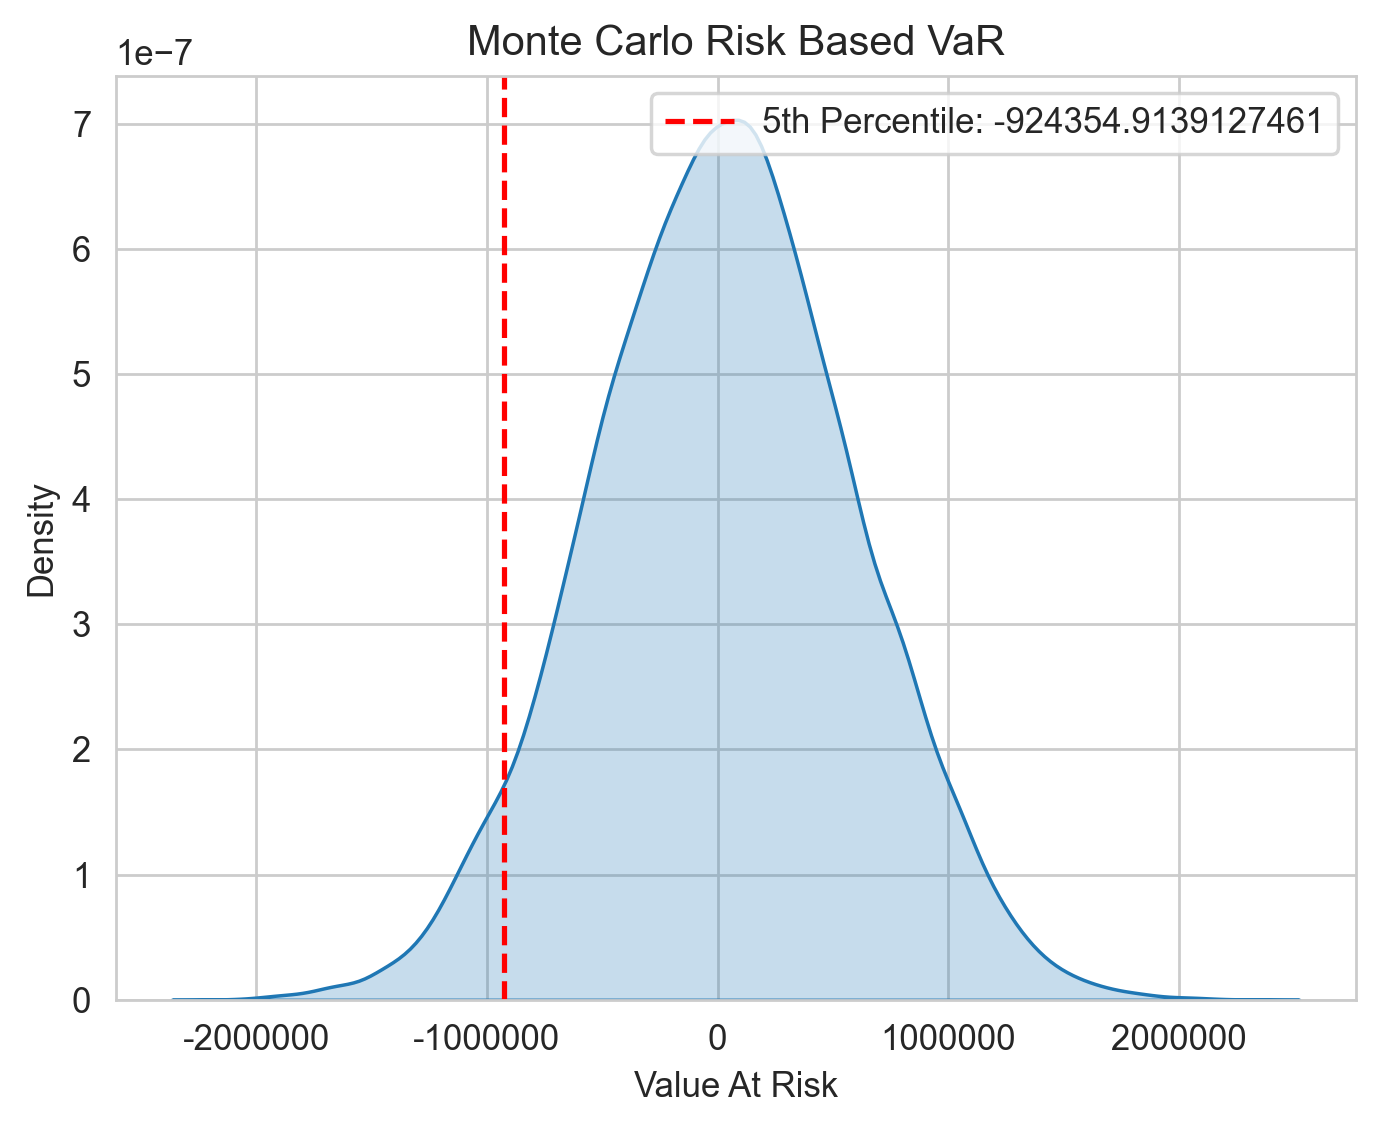

In [155]:
# Calculate the 5th percentile
fifth_percentile = np.percentile(monteCarlo_Risk_Var, 5)

plt.figure(dpi=250)
sns.set_style('whitegrid')
sns.kdeplot(np.array(monteCarlo_Risk_Var).reshape(no_of_simulations, 1), fill=True)
plt.title('Monte Carlo Risk Based VaR')
plt.xlabel('Value At Risk')
plt.ylabel('Density')

plt.axvline(x=fifth_percentile, color='r', linestyle='--', label=f'5th Percentile: {fifth_percentile}')

formatter = FuncFormatter(lambda x, _: f'{int(x)}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()

plt.show()

In [156]:
print(f'Monte Carlo Full Revaluation VaR is {np.percentile(np.array(monteCarlo_Full_Revalue_Var),5)}')

Monte Carlo Full Revaluation VaR is -938323.5072340011


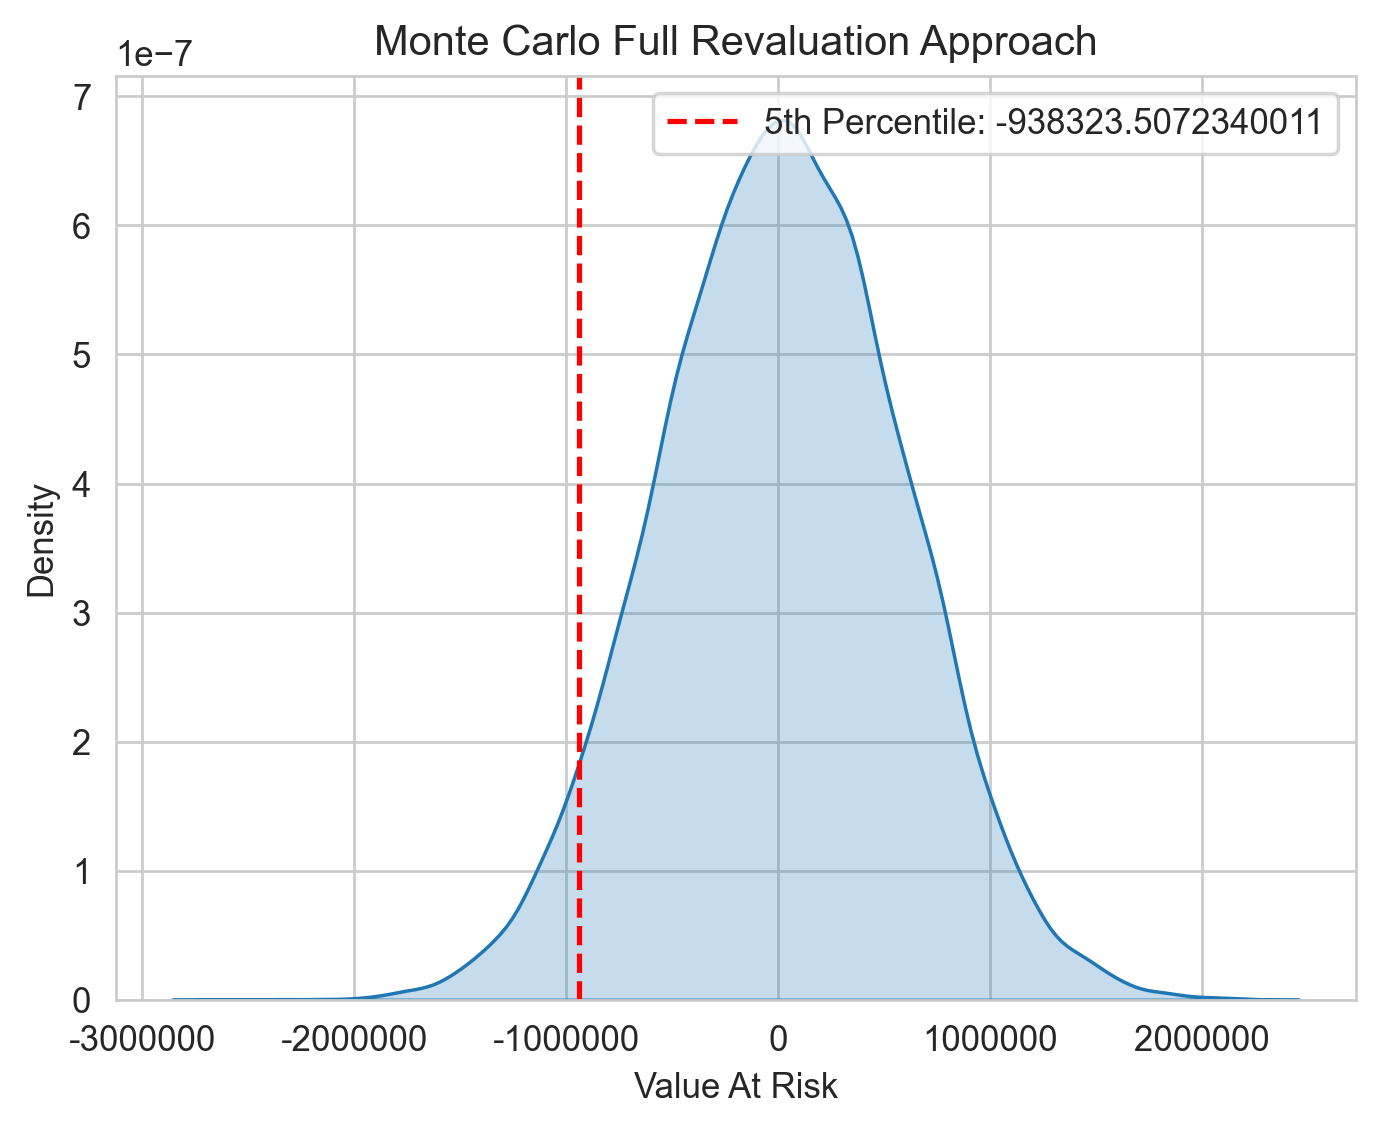

In [157]:
# Calculate the 5th percentile
fifth_percentile = np.percentile(monteCarlo_Full_Revalue_Var, 5)

plt.figure(dpi=250)
sns.set_style('whitegrid')
sns.kdeplot(np.array(monteCarlo_Full_Revalue_Var).reshape(no_of_simulations, 1), fill=True)
plt.title('Monte Carlo Full Revaluation Approach')
plt.xlabel('Value At Risk')
plt.ylabel('Density')

plt.axvline(x=fifth_percentile, color='r', linestyle='--', label=f'5th Percentile: {fifth_percentile}')
formatter = FuncFormatter(lambda x, _: f'{int(x)}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()

plt.show()

### Historical VaR

In [158]:
#Full Revaluation Based
historical_full_var = []
baseCurve = SOFR.iloc[:,6:16].iloc[-1].values
for i in range(len(sofrDailyChanges)):
    stockreturn = (1000000 * stockDailyChanges.iloc[i].values).sum()
    newCurve = baseCurve + sofrDailyChanges.iloc[:,6:16].iloc[i].values
    swapreturn = price_sofr(notional, fixed_rate, get_discount_factors(newCurve)) - \
                price_sofr(notional, fixed_rate, get_discount_factors(baseCurve))
    historical_full_var.append(swapreturn + stockreturn)

In [159]:
print(f'Historical Full Revaluation VaR is {np.percentile(np.array(historical_full_var), 5)}')

Historical Full Revaluation VaR is -966173.2175561604


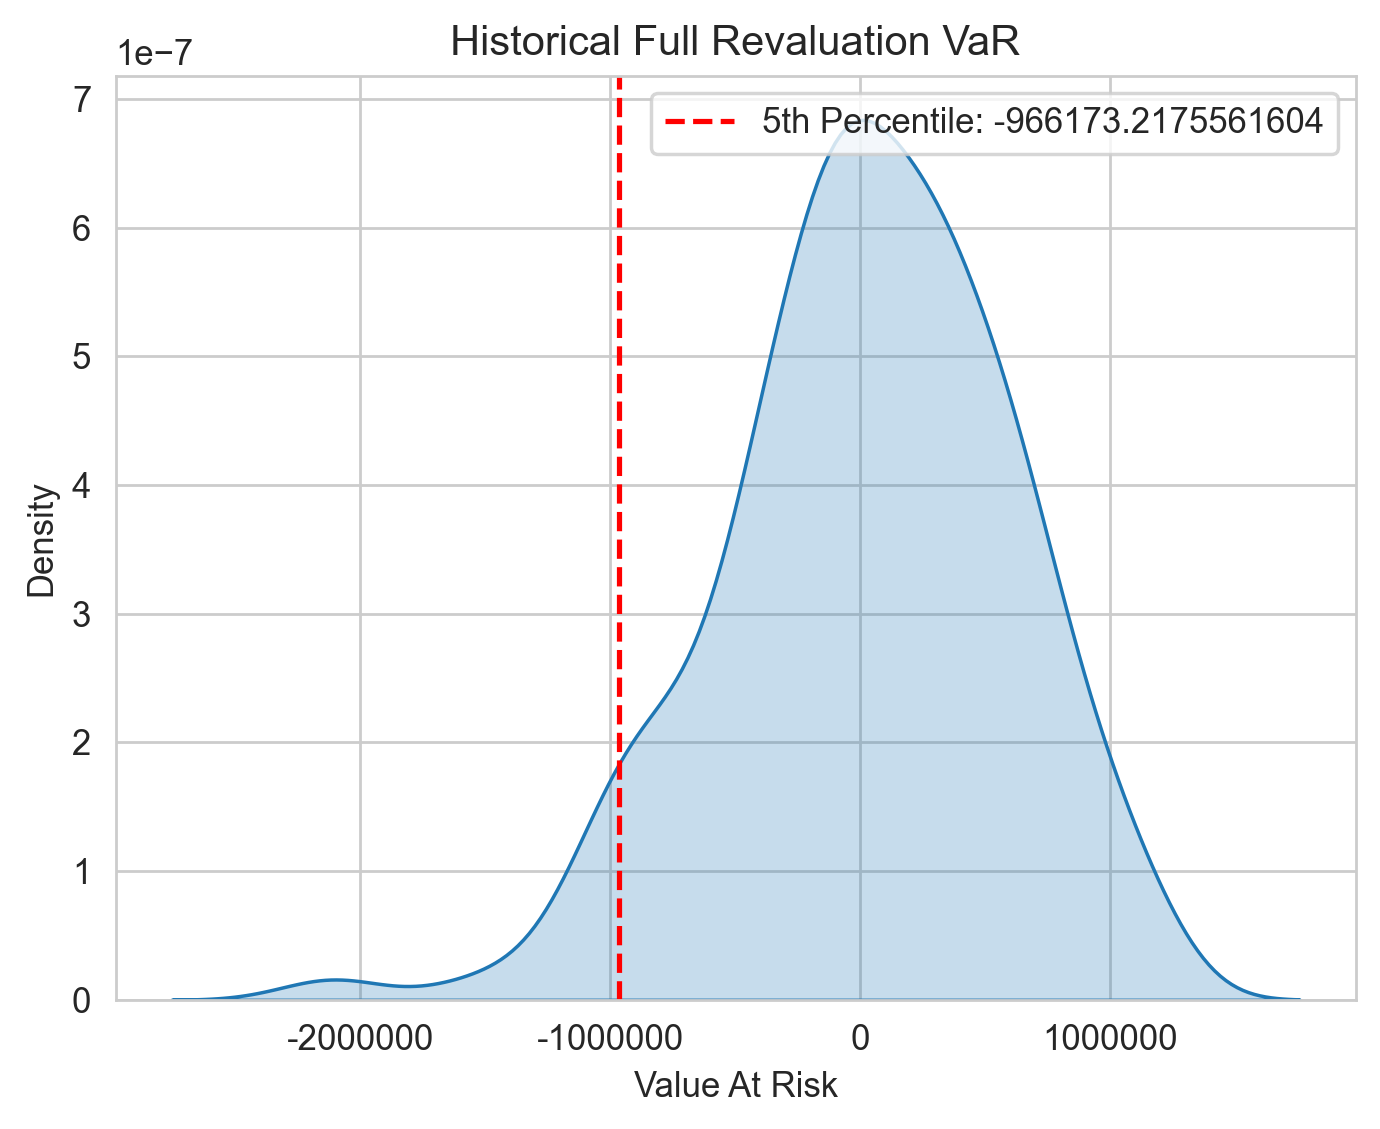

In [160]:
# Calculate the 5th percentile
fifth_percentile = np.percentile(historical_full_var, 5)

plt.figure(dpi=250)
sns.set_style('whitegrid')
sns.kdeplot(np.array(historical_full_var), fill=True)
plt.title('Historical Full Revaluation VaR')
plt.xlabel('Value At Risk')
plt.ylabel('Density')

plt.axvline(x=fifth_percentile, color='r', linestyle='--', label=f'5th Percentile: {fifth_percentile}')
formatter = FuncFormatter(lambda x, _: f'{int(x)}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()

plt.show()

In [161]:
#Risk Based Approach

pv01 = get_pv01(notional, 
                fixed_rate, 
                SOFR.iloc[:,6:16].iloc[-1].values, 
                price_sofr(notional, 
                           fixed_rate, 
                           get_discount_factors(SOFR.iloc[:,6:16].iloc[-1].values)))

historical_risk_var = []
for i in range(len(data)):
    historical_risk_var.append(pv01@data.iloc[i].values)
    
print(f'Historical Risk Based VaR is {np.percentile(np.array(historical_risk_var), 5)}')

Historical Risk Based VaR is -960687.7194579934


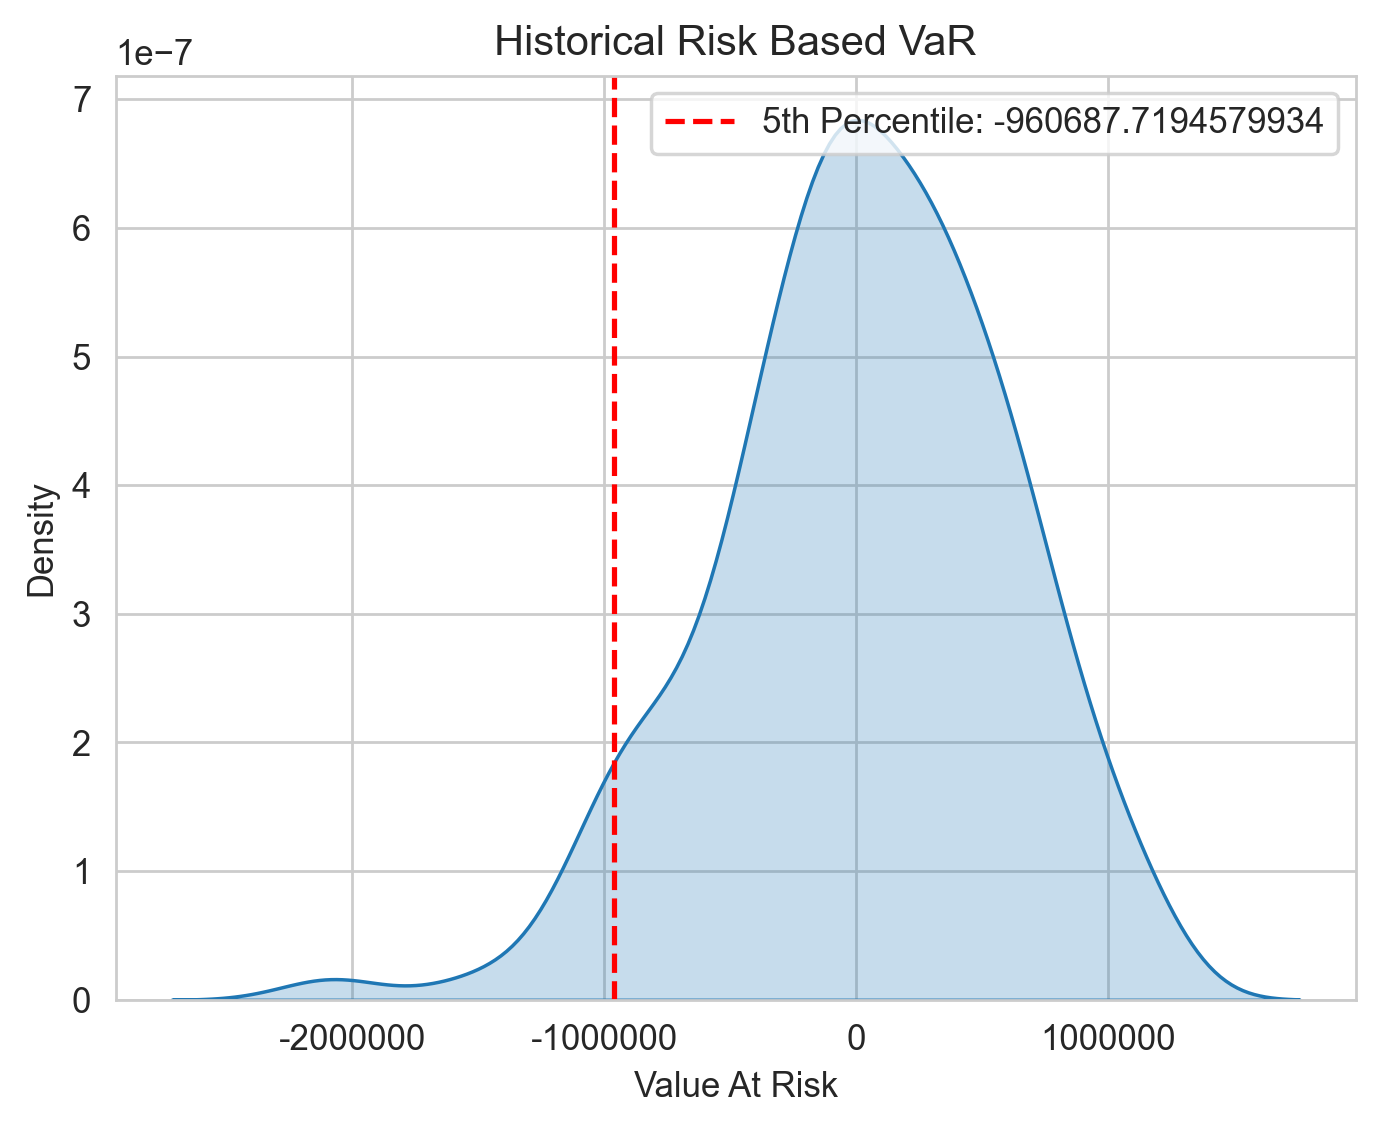

In [162]:
# Calculate the 5th percentile
fifth_percentile = np.percentile(historical_risk_var, 5)

plt.figure(dpi=250)
sns.set_style('whitegrid')
sns.kdeplot(np.array(historical_risk_var), fill=True)
plt.title('Historical Risk Based VaR')
plt.xlabel('Value At Risk')
plt.ylabel('Density')

plt.axvline(x=fifth_percentile, color='r', linestyle='--', label=f'5th Percentile: {fifth_percentile}')
formatter = FuncFormatter(lambda x, _: f'{int(x)}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()

plt.show()

In [163]:
#Final Report
PortfolioVaR = pd.DataFrame({'Parametric VaR': abs(parametric_var[0][0]),
                            'Risk Based Monte Carlo VaR' : abs(np.percentile(np.array(monteCarlo_Risk_Var), 5)),
                            'Full Revaluation Based Monte Carlo VaR' : abs(np.percentile(np.array(monteCarlo_Full_Revalue_Var), 5)),
                            'Risk Based Historical VaR' : abs(np.percentile(np.array(historical_risk_var), 5)),
                            'Full Revaluation Historical VaR' : abs(np.percentile(np.array(historical_full_var), 5))},
                           index=range(1)).T

PortfolioVaR.columns = ['Value At Risk']

styled_df = PortfolioVaR.style.set_table_styles([
    # Style for the header
    {'selector': 'th', 'props': [('font-size', '16pt'), 
                                 ('text-align', 'center'),
                                 ('font-weight', 'bold'),
                                 ('color', 'black'),
                                 ('background-color', 'white')]},
    # Style for the data
    {'selector': 'td', 'props': [('text-align', 'center'),
                                 ('font-size', '12pt'),
                                 ('font-family', 'Arial, sans-serif')]},
    # Style for the index
    {'selector': 'th.row_heading', 'props': [('text-align', 'left'),
                                             ('font-size', '12pt'),
                                             ('font-family', 'Arial, sans-serif')]},
    # Style for the index name
    {'selector': 'th.blank', 'props': [('text-align', 'center'),
                                        ('font-size', '12pt'),
                                        ('font-family', 'Arial, sans-serif')]},
])

styled_df

,Value At Risk
Parametric VaR,929358.900615
Risk Based Monte Carlo VaR,924354.913913
Full Revaluation Based Monte Carlo VaR,938323.507234
Risk Based Historical VaR,960687.719458
Full Revaluation Historical VaR,966173.217556
